In [149]:
# Roast SVM analysis - Aloi Davide (PhD student - University of Birmingham)
# Decstiption: add

# Imports
import warnings
warnings.filterwarnings("ignore")
import os
import glob
import numpy as np
from nilearn import image, plotting
from nilearn.image import new_img_like
from scipy import ndimage
import scipy.io


In [148]:
## Parameters and variables: 
results_folder = 'D:\\roast-chapter3\\wp_all_results\\' # Folder with results (current density)
main_folder = 'C:\\Users\\davide\\Documents\\GitHub\\wp1_2_roast\\' # Project folder
dcm_results_folder = 'C:\\Users\\davide\\Documents\\GitHub\\wp1_2_roast\\all_dcm_results\\' # Folder with dcm results

# Datasets names and subjects lists
db_names = ['wp2a', 'wp1b'] # waiting for wp1a results from Davinia
#db_names = ['wp2a']

# ROIs
## Loading AAL3 atlas and extracting M1 / Thalamus ROIs (regions of interest)
# AAL3 atlas paper: https://www.oxcns.org/papers/607%20Rolls%20Huang%20Lin%20Feng%20Joliot%202020%20AAL3.pdf 
AAl3_path = os.path.join(main_folder, 'rois', 'AAL3v1_1mm.nii')
AAL3_atlas = image.load_img(AAl3_path)

## Creating M1, Th and cerebellar masks from the AAL3 atlas. Load MNI template.
# AAL3 index for left M1 = 1
m1 = image.math_img("np.where(img == 1, 1, 0)", img = AAL3_atlas) 
# AAL3 index for TH = 121 - 149 (odd values only (left thalamus)) --> I'm not convinced about this one, ask Davinia
th = image.math_img("np.where(np.isin(img, np.arange(121, 150, 2)), 1, 0)", img = AAL3_atlas) 
# AAL3 index for right Cerebellum (cb) (102 and 108: cerebellar lobes IV-V and VIII)
cb = image.math_img("np.where(np.isin(img, np.array([102, 108])), 1, 0)", img = AAL3_atlas)

In [151]:
# Dividing participants into responders / non-responders, based on DCM values
labels = []

for db_id, db in enumerate(db_names):

    # Loading DCM results (nb: the unthresholded ones, for the correlation analysis)
    DCM = np.load(os.path.join(dcm_results_folder, db + '_dcm_thresholded.npy'))
    DCM_sham = np.load(os.path.join(dcm_results_folder, db + '_dcm_sham_thresholded.npy'))

    # Loading current density results for dataset db
    #cd_scans = image.load_img(os.path.join(results_folder, db + '_all_cd_maps.nii'))
    print('Analysing dataset ' + db + ' - N. subjects: ' + str(DCM.shape[0]))

    # Converting DCM diagonal values to Hz
    funcHz = lambda x: (-0.5*(np.exp(x)))+0.5 if x != 0 else 0
    
    db_labels = []
    # Conversion of diagonal values to Hz + recentering on 0
    for i in range(0, DCM.shape[0]): 
        diag = np.diagonal(DCM[i,:,:])
        diag_converted = []
        for element in diag:
            diag_converted.append(funcHz(element))
        np.fill_diagonal(DCM[i,:,:], np.array(diag_converted))
        
        # Criteria for labelling (very questionable, change)
        label = [1 if DCM[i,0:3,0:3].sum() > 0 else 0]
        db_labels.append(label)

    print(DCM)
    labels.append(db_labels)

for label in labels:
    print(label)

Analysing dataset wp2a - N. subjects: 22
[[[ 0.         -0.14524401  0.          0.27560144]
  [-0.07975794  0.          0.          0.16814571]
  [ 0.         -0.1373137   0.          0.        ]
  [ 0.         -0.15147347  0.          0.        ]]

 [[ 0.15193436  0.          0.          0.        ]
  [ 0.          0.         -0.13382803  0.18316923]
  [ 0.40141591  0.          0.          0.        ]
  [ 0.          0.         -0.16035369  0.        ]]

 [[ 0.18780946  0.         -0.30671811  0.52496502]
  [-0.05098956  0.          0.          0.19700627]
  [ 0.          0.          0.          0.20982005]
  [ 0.          0.          0.          0.        ]]

 [[-0.23807737  0.          0.33035092  0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.         

In [134]:
wp2a_ref = image.load_img(os.path.join(results_folder, 'wp2a' + '_all_cd_maps.nii')) # just used for the new img like function
wp2a = image.load_img(os.path.join(results_folder, 'wp2a' + '_all_cd_maps.nii')).get_fdata()
wp1b = image.load_img(os.path.join(results_folder, 'wp1b' + '_all_cd_maps.nii')).get_fdata()

all_scans = np.concatenate((wp2a, wp1b), axis = 3)

In [136]:
# Resampling ROIs (done only once)
if not 'm1_resampled' in locals():
    m1_resampled = image.resample_to_img(m1, cd_scans, interpolation = 'nearest')
    th_resampled = image.resample_to_img(th, cd_scans, interpolation = 'nearest')
    cb_resampled = image.resample_to_img(cb, cd_scans, interpolation = 'nearest')

In [145]:
from nilearn.decoding import Decoder
from sklearn.model_selection import KFold

n_folds = 10

decoder = Decoder(
    estimator='svc', mask=m1_resampled,
    standardize=True, cv=n_folds,
    screening_percentile = 10,
    scoring='accuracy'
)

all_labels = np.concatenate((np.array(labels[0]), np.array(labels[1])), axis = 0).T[0]
print(all_labels)


[0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0
 0 1 0 1 1 1]


Classification accuracy: 47.0% std: 12.1%


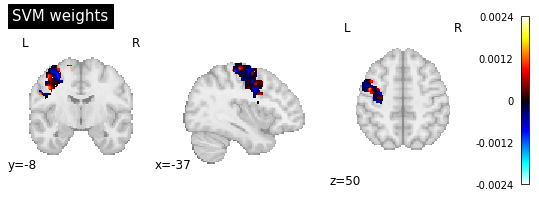

In [147]:
all_scans_nibabel = new_img_like(wp2a_ref, all_scans)
decoder.fit(all_scans_nibabel, all_labels)

#print(decoder.cv_scores_)

print('Classification accuracy: ' + str(np.mean(decoder.cv_scores_[0])*100) + '% std: '
      + str(round(np.std((decoder.cv_scores_[0])),3)*100) + '%')

weight_img = decoder.coef_img_[1]
from nilearn.plotting import plot_stat_map, show
plot_stat_map(weight_img, title='SVM weights', draw_cross = False)

In [154]:
import cupy as cp

x = cp.array([1, 2, 3])
print(x.device)

print(cp.cuda.runtime.getDeviceCount())


<CUDA Device 0>
1


In [168]:
# Python program to 
# demonstrate speed comparison
# between cupy and numpy
  
# Importing modules
import cupy as cp
import numpy as np
import time
  
# NumPy and CPU Runtime
s = time.time()
x_cpu = np.ones((1000, 1000, 100))
e = time.time()
print("Time consumed by numpy: ", e - s)

# CuPy and GPU Runtime
#s = time.time()
x_gpu = cp.ones((1000, 1000, 100))
#e = time.time()
#print("\nTime consumed by cupy: " + str(e - s))

Time consumed by numpy:  0.7641842365264893


KeyboardInterrupt: 